In [1]:
"""
Randomized Optimization - Part 2

https://gatech.instructure.com/courses/122126/assignments/557950

"""
#1 Verify imports
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import mlrose_hiive as mlrose
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import time

# Allow plots to appear within the notebook:
%matplotlib inline

print("All imports are good")

All imports are good


In [25]:
#2 Get & preprocess the data

# From Assignment 1:
dataset = fetch_openml(name='phoneme') 
X = dataset.data #matrix
y = dataset.target #vector

# Split data into train and test subsets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

# Normalize feature data
scaler = MinMaxScaler()
# One hot encode target values
one_hot = OneHotEncoder()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Note, since the targets are already split up into Class 1 or 2, 
# this OneHotEncoding may be unnecessary / redundant, 
# but still, it's good practice as a beginner
y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()

#Other globals:
# Using optimums values from Assignment 1 for my_hidden_nodes, my_activation. 
# Alpha and solver from Assignment 1 don't apply here.
my_hidden_nodes = []
for i in range(9):  #number of hidden layers
    my_hidden_nodes.append(8) #number of hidden nodes at each hidden layer
#print("length of my_hidden_nodes: " + str(len(my_hidden_nodes)))
my_activation = 'tanh'

# Ranges & multipliers we'll explore for each algorithm:
max_iters_start = 1
max_iters_max = 256
max_iters_multiplier = 2
learning_rate_start = 0.01
learning_rate_max = 10
learning_rate_multiplier = 10

# Setting this to false because I don't understand it well enough to trust what the source code 
# from mlrose does when it's true
my_bias = False 
# Note: in scikit-learn, "random_state = 0" was valid; in mlrose, it is required to be a positive integer :/
my_random_state = 1

# Acceptable defaults:
#is_classifer (bool, default: True)
#early_stopping (bool, default: False) 
#clip_max (float, default: 1e+10) 
#max_attempts (int, default: 10)
#curve (bool, default: False)

# Ranges & multipliers specific to SA
init_temp_range = range(1,21)
min_temp_start = 0.001 #same best score found at min_temp = 0.0001 and smaller
min_temp_max = 1.0
min_temp_multiplier = 10

print("Data gotten and preprocessed, and other globals initialized")

Data gotten and preprocessed, and other globals initialized


In [28]:
#3 Functions

def getTime(seconds):
    if int(seconds / 60) == 0:
        return str(int(seconds)) + " second(s)"
    minutes = int(seconds / 60)
    seconds = int(seconds % 60)
    if int(minutes / 60) == 0:
        return str(minutes) + " minute(s) and " + str(seconds) + " second(s)"
    hours = int(minutes / 60)
    minutes = int(minutes % 60)
    # Assuming this won't be called for any time span greater than 24 hours
    return str(hours) + " hour(s), " + str(minutes) + " minute(s), and " + str(seconds) + " second(s)"

def scatter_plot_3d(x_axis, y_axis, z_axis, x_label, y_label, z_label):
    #3d scatter plot:
    fig = plt.figure()
    axes = fig.add_subplot(111, projection='3d')
    axes.scatter(x_axis, y_axis, z_axis)
    
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_zlabel(z_label)
    plt.show()

def predict_against_test_set(nn_model1):
    nn_model1.fit(X_train_scaled, y_train_hot)
    y_test_pred = nn_model1.predict(X_test_scaled)
    y_test_accuracy = accuracy_score(y_test_hot, y_test_pred)
    print("Predicting against test set: " + str(round(y_test_accuracy, 4)))
    
# Neural network - gradient descent
def NN_GD(is_debug=False):
    my_algorithm = 'gradient_descent'
    best_accuracy = 0
    best_max_iters = 0
    best_learning_rate = 0
    max_iters_axis = []
    learning_rate_axis = []
    y_train_accuracies = []
    start = time.time()
    my_max_iters = max_iters_start
    while my_max_iters <= max_iters_max:
        my_learning_rate = learning_rate_start
        while my_learning_rate <= learning_rate_max:
            max_iters_axis.append(my_max_iters)
            learning_rate_axis.append(my_learning_rate)
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                 algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
                 learning_rate=my_learning_rate, random_state=my_random_state)
            nn_model1.fit(X_train_scaled, y_train_hot)
            # Predict labels for train set and assess accuracy
            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at max_iters = " + my_max_iters \
                    + "; learning_rate = " + str(my_learning_rate) + ": " \
                    + str(round(y_train_accuracy,4)))
                best_accuracy = y_train_accuracy
                best_max_iters = my_max_iters
                best_learning_rate = my_learning_rate
            my_learning_rate *= learning_rate_multiplier
        my_max_iters *= max_iters_multiplier
    end = time.time()
    print("Best accuracy " + str(round(best_accuracy, 4)) + " found at max_iters = " \
              + str(best_max_iters) + " & learning_rate = " + str(best_learning_rate) \
              + " at " + getTime(end - start))
    scatter_plot_3d(max_iters_axis, learning_rate_axis, y_train_accuracies, \
                    'max_iters', 'learning_rate', 'y_train_accuracy')
    
# Neural network - randomized hill climbing
def NN_RHC(is_debug=False):
    my_algorithm = 'random_hill_climb'
    restarts_range = range(11) #0-10

    best_accuracy = 0
    best_max_iters = 0
    best_learning_rate = 0

    max_iters_axis = []
    learning_rate_axis = []
    y_train_accuracies = []
    
    print("Exploring Randomized hill climbing...")
    start = time.time()
    
    # Holding restarts constant
    my_max_iters = max_iters_start
    while my_max_iters <= max_iters_max:
        my_learning_rate = learning_rate_start
        while my_learning_rate <= learning_rate_max:
            max_iters_axis.append(my_max_iters)
            learning_rate_axis.append(my_learning_rate)
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                 algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
                 learning_rate=my_learning_rate, random_state=my_random_state, restarts=10)
            nn_model1.fit(X_train_scaled, y_train_hot)
            # Predict labels for train set and assess accuracy
            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at my_learning_rate = " + str(my_learning_rate) \
                  + "; my_max_iters = " + str(my_max_iters) + ": " + str(round(y_train_accuracy,4)))
                best_accuracy = y_train_accuracy
                best_max_iters = my_max_iters
                best_learning_rate = my_learning_rate

            my_learning_rate *= learning_rate_multiplier
        my_max_iters *= max_iters_multiplier
        
    print("Holding restarts constant at 10, best accuracy " + str(round(best_accuracy, 4)) \
          + " found at max_iters = " + str(best_max_iters) + " & learning_rate = " + str(best_learning_rate))
    
    scatter_plot_3d(max_iters_axis, learning_rate_axis, y_train_accuracies, \
                    'max_iters', 'learning_rate', 'y_train_accuracy')
    
    # Holding max_iters constant
    restarts_axis = []
    learning_rate_axis = []
    y_train_accuracies = []

    best_accuracy = 0
    best_restarts = -1
    best_learning_rate = 0

    for my_restarts in restarts_range:
        my_learning_rate = learning_rate_start
        while my_learning_rate <= learning_rate_max:
            restarts_axis.append(my_restarts)
            learning_rate_axis.append(my_learning_rate)
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                 algorithm=my_algorithm, max_iters=best_max_iters, bias=my_bias, \
                 learning_rate=my_learning_rate, random_state=my_random_state, restarts=my_restarts)
            nn_model1.fit(X_train_scaled, y_train_hot)

            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at my_learning_rate = " + str(my_learning_rate) \
                  + "; my_restarts = " + str(my_restarts) + ": " + str(round(y_train_accuracy,4)))
                best_accuracy = y_train_accuracy
                best_restarts = my_restarts
                best_learning_rate = my_learning_rate

            my_learning_rate *= learning_rate_multiplier
    
    print("Holding max_iters constant at " + str(best_max_iters) + ", best accuracy " \
          + str(round(best_accuracy, 4)) + " found at restarts = " + str(best_restarts) \
          + " & learning_rate = " + str(best_learning_rate))

    scatter_plot_3d(restarts_axis, learning_rate_axis, y_train_accuracies, \
                    'restarts', 'learning_rate', 'y_train_accuracy')
    
    # Performance vs number of iterations
    print("Performance vs number of iterations:")
    max_iters_axis = []
    y_train_accuracies = []
    my_max_iters = max_iters_start
    while my_max_iters <= max_iters_max:
        nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
             algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
             learning_rate=best_learning_rate, random_state=my_random_state, restarts=best_restarts)
        nn_model1.fit(X_train_scaled, y_train_hot)
        y_train_pred = nn_model1.predict(X_train_scaled)
        y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
        max_iters_axis.append(my_max_iters)
        y_train_accuracies.append(y_train_accuracy)
        my_max_iters *= max_iters_multiplier
    plt.plot(max_iters_axis, y_train_accuracies)
    plt.xlabel("Max iters")
    plt.ylabel("y_train_accuracy")
    plt.show()
    
    # Reinitialize model with optimal hyperparameters
    nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
         algorithm=my_algorithm, max_iters=best_max_iters, bias=my_bias, \
         learning_rate=best_learning_rate, random_state=my_random_state, restarts=best_restarts)

    # Predict for test set and assess accuracy
    predict_against_test_set(nn_model1)
    
    end = time.time()
    print(my_algorithm + " took this much time: " + getTime(end - start))
    
# Neural network - simulated annealing
def NN_SA(is_debug=False):
    my_algorithm = 'simulated_annealing'
    
    schedule_range = range(3)
    
    best_accuracy = 0
    best_max_iters = 0
    best_learning_rate = 0

    max_iters_axis = []
    learning_rate_axis = []
    y_train_accuracies = []
    
    print("Exploring Simulated annealing...")
    start = time.time()
    
    # Holding schedule constant at default GeomDecay
    my_max_iters = max_iters_start
    while my_max_iters <= max_iters_max:
        my_learning_rate = learning_rate_start
        while my_learning_rate <= learning_rate_max:
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                     algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
                     learning_rate=my_learning_rate, random_state=my_random_state)
            nn_model1.fit(X_train_scaled, y_train_hot)
            
            max_iters_axis.append(my_max_iters)
            learning_rate_axis.append(my_learning_rate)
            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at my_max_iters = " + str(my_max_iters) \
                  + "; my_learning_rate = " + str(my_learning_rate) + ": " + str(round(y_train_accuracy,4)))
                best_accuracy = y_train_accuracy
                best_max_iters = my_max_iters
                best_learning_rate = my_learning_rate

            my_learning_rate *= learning_rate_multiplier
        my_max_iters *= max_iters_multiplier

    print("Holding schedule constant at default GeomDecay, best accuracy " + str(round(best_accuracy, 4)) \
          + " found at max_iters = " + str(best_max_iters) + " & learning_rate = " + str(best_learning_rate))
    
    scatter_plot_3d(max_iters_axis, learning_rate_axis, y_train_accuracies, \
                    'max_iters', 'learning_rate', 'y_train_accuracy')
    
    # Performance vs number of iterations
    print("Performance vs number of iterations:")
    max_iters_axis = []
    y_train_accuracies = []
    my_max_iters = max_iters_start
    while my_max_iters <= max_iters_max:
        nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
             algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
             learning_rate=best_learning_rate, random_state=my_random_state)
        nn_model1.fit(X_train_scaled, y_train_hot)
        y_train_pred = nn_model1.predict(X_train_scaled)
        y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
        max_iters_axis.append(my_max_iters)
        y_train_accuracies.append(y_train_accuracy)
        my_max_iters *= max_iters_multiplier
    plt.plot(max_iters_axis, y_train_accuracies)
    plt.xlabel("Max iters")
    plt.ylabel("y_train_accuracy")
    plt.show()
    
    # Reinitialize model with optimal hyperparameters
    nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
         algorithm=my_algorithm, max_iters=best_max_iters, bias=my_bias, \
         learning_rate=best_learning_rate, random_state=my_random_state)

    # Predict for test set and assess accuracy
    predict_against_test_set(nn_model1)
    
    print("Exploring various decay schedules: ")

    NN_SA_GeomDecay(my_algorithm, best_max_iters, best_learning_rate, init_temp_range, \
                    min_temp_start, min_temp_max, min_temp_multiplier, is_debug)
    NN_SA_ArithDecay(my_algorithm, best_max_iters, best_learning_rate, init_temp_range, \
                    min_temp_start, min_temp_max, min_temp_multiplier, is_debug)
    NN_SA_ExpDecay(my_algorithm, best_max_iters, best_learning_rate, init_temp_range, \
                    min_temp_start, min_temp_max, min_temp_multiplier, is_debug)
    
    end = time.time()
    print(my_algorithm + " took this much time: " + getTime(end - start))
    
def NN_SA_GeomDecay(my_algorithm, my_max_iters, my_learning_rate, init_temp_range, \
                    min_temp_start, min_temp_max, min_temp_multiplier, is_debug=False):
    decay_start = 0.1
    decay_max = 1.0
    decay_increment = 0.3
    
    best_init_temp = 0
    best_decay = 0
    best_accuracy = 0
    
    init_temp_axis = []
    decay_axis = []
    y_train_accuracies = []
    
    print("Exploring geometric decay: ")
    
    # Holding min_temp constant
    for my_init_temp in init_temp_range:
        my_decay = decay_start
        while my_decay < decay_max:
            geom_decay = mlrose.GeomDecay(init_temp=my_init_temp, decay=my_decay, min_temp=min_temp_start)
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                 algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
                 learning_rate=my_learning_rate, random_state=my_random_state, schedule=geom_decay)
            nn_model1.fit(X_train_scaled, y_train_hot)
            
            init_temp_axis.append(my_init_temp)
            decay_axis.append(my_decay)
            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at my_init_temp = " + str(my_init_temp) \
                  + "; my_decay = " + str(my_decay) + " : " + str(round(y_train_accuracy,4)))
                best_init_temp = my_init_temp
                best_decay = my_decay
                best_accuracy = y_train_accuracy

            my_decay += decay_increment
    
    print("Holding min_temp constant at " + str(min_temp_start) + ", best accuracy " \
          + str(round(best_accuracy, 4)) + " found at init_temp = " + str(best_init_temp) \
          + " & decay = " + str(best_decay))
    
    scatter_plot_3d(init_temp_axis, decay_axis, y_train_accuracies, \
                    'init_temp', 'decay', 'y_train_accuracy')
    
    # Holding decay constant
    best_init_temp = 0
    best_min_temp = 0
    best_accuracy = 0
    
    init_temp_axis = []
    min_temp_axis = []
    y_train_accuracies = []
    
    for my_init_temp in init_temp_range:
        my_min_temp = min_temp_start
        while my_min_temp <= min_temp_max:
            geom_decay = mlrose.GeomDecay(init_temp=my_init_temp, decay=best_decay, min_temp=my_min_temp)
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                 algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
                 learning_rate=my_learning_rate, random_state=my_random_state, schedule=geom_decay)
            nn_model1.fit(X_train_scaled, y_train_hot)
            
            init_temp_axis.append(my_init_temp)
            min_temp_axis.append(my_min_temp)
            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at my_init_temp = " + str(my_init_temp) \
                  + "; my_min_temp = " + str(my_min_temp) + " : " + str(round(y_train_accuracy,4)))
                best_init_temp = my_init_temp
                best_min_temp = my_min_temp
                best_accuracy = y_train_accuracy
            
            my_min_temp *= min_temp_multiplier
    
    print("Holding decay constant at " + str(best_decay) + ", best accuracy " + str(round(best_accuracy, 4)) \
          + " found at init_temp = " + str(best_init_temp) + " & min_temp = " + str(best_min_temp))
    
    scatter_plot_3d(init_temp_axis, min_temp_axis, y_train_accuracies, \
                    'init_temp', 'min_temp', 'y_train_accuracy')
    
    # Performance vs number of iterations
    print("Performance vs number of iterations:")
    max_iters_axis = []
    y_train_accuracies = []
    my_max_iters = max_iters_start
    while my_max_iters <= max_iters_max:
        geom_decay = mlrose.GeomDecay(init_temp=best_init_temp, decay=best_decay, min_temp=best_min_temp)
        nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
             algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
             learning_rate=my_learning_rate, random_state=my_random_state, schedule=geom_decay)
        nn_model1.fit(X_train_scaled, y_train_hot)
        y_train_pred = nn_model1.predict(X_train_scaled)
        y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
        max_iters_axis.append(my_max_iters)
        y_train_accuracies.append(y_train_accuracy)
        my_max_iters *= max_iters_multiplier
    plt.plot(max_iters_axis, y_train_accuracies)
    plt.xlabel("Max iters")
    plt.ylabel("y_train_accuracy")
    plt.show()
    
    # Reinitialize model with optimal hyperparameters
    geom_decay = mlrose.GeomDecay(init_temp=best_init_temp, decay=best_decay, min_temp=best_min_temp)
    nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
         algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
         learning_rate=my_learning_rate, random_state=my_random_state, schedule=geom_decay)

    # Predict for test set and assess accuracy
    predict_against_test_set(nn_model1)
    
def NN_SA_ArithDecay(my_algorithm, my_max_iters, my_learning_rate, init_temp_range, \
                    min_temp_start, min_temp_max, min_temp_multiplier, is_debug=False):
    decay_start = 0.1
    decay_max = 1.0
    decay_increment = 0.3
    
    best_init_temp = 0
    best_decay = 0
    best_accuracy = 0
    
    init_temp_axis = []
    decay_axis = []
    y_train_accuracies = []

    print("Exploring arithmetic decay: ")

    # Holding min_temp constant
    for my_init_temp in init_temp_range:
        my_decay = decay_start
        while my_decay < decay_max:
            arith_decay = mlrose.ArithDecay(init_temp=my_init_temp, decay=my_decay, min_temp=min_temp_start)
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                 algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
                 learning_rate=my_learning_rate, random_state=my_random_state, schedule=arith_decay)
            nn_model1.fit(X_train_scaled, y_train_hot)
            
            init_temp_axis.append(my_init_temp)
            decay_axis.append(my_decay)
            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at my_init_temp = " + str(my_init_temp) \
                  + "; my_decay = " + str(my_decay) + " : " + str(round(y_train_accuracy,4)))
                best_init_temp = my_init_temp
                best_decay = my_decay
                best_accuracy = y_train_accuracy
            
            my_decay += decay_increment
             
    print("Holding min_temp constant at " + str(min_temp_start) + ", best accuracy " \
          + str(round(best_accuracy, 4)) + " found at init_temp = " + str(best_init_temp) \
          + " & decay = " + str(best_decay))
    
    scatter_plot_3d(init_temp_axis, decay_axis, y_train_accuracies, \
                    'init_temp', 'decay', 'y_train_accuracy')

    # Holding decay constant
    best_init_temp = 0
    best_min_temp = 0
    best_accuracy = 0
    
    init_temp_axis = []
    min_temp_axis = []
    y_train_accuracies = []
    
    for my_init_temp in init_temp_range:
        my_min_temp = min_temp_start
        while my_min_temp <= min_temp_max:
            arith_decay = mlrose.ArithDecay(init_temp=my_init_temp, decay=best_decay, min_temp=my_min_temp)
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                 algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
                 learning_rate=my_learning_rate, random_state=my_random_state, schedule=arith_decay)
            nn_model1.fit(X_train_scaled, y_train_hot)
            
            init_temp_axis.append(my_init_temp)
            min_temp_axis.append(my_min_temp)
            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at my_init_temp = " + str(my_init_temp) \
                  + "; my_min_temp = " + str(my_min_temp) + " : " + str(round(y_train_accuracy,4)))
                best_init_temp = my_init_temp
                best_min_temp = my_min_temp
                best_accuracy = y_train_accuracy            
            my_min_temp *= min_temp_multiplier
        
    print("Holding decay constant at " + str(best_decay) + ", best accuracy " + str(round(best_accuracy, 4)) \
          + " found at init_temp = " + str(best_init_temp) + " & min_temp = " + str(best_min_temp))
    
    scatter_plot_3d(init_temp_axis, min_temp_axis, y_train_accuracies, \
                    'init_temp', 'min_temp', 'y_train_accuracy')
    
    # Performance vs number of iterations
    print("Performance vs number of iterations:")
    max_iters_axis = []
    y_train_accuracies = []
    my_max_iters = max_iters_start
    while my_max_iters <= max_iters_max:
        arith_decay = mlrose.ArithDecay(init_temp=best_init_temp, decay=best_decay, min_temp=best_min_temp)
        nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
             algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
             learning_rate=my_learning_rate, random_state=my_random_state, schedule=arith_decay)
        nn_model1.fit(X_train_scaled, y_train_hot)
        y_train_pred = nn_model1.predict(X_train_scaled)
        y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
        max_iters_axis.append(my_max_iters)
        y_train_accuracies.append(y_train_accuracy)
        my_max_iters *= max_iters_multiplier
    plt.plot(max_iters_axis, y_train_accuracies)
    plt.xlabel("Max iters")
    plt.ylabel("y_train_accuracy")
    plt.show()
    
    # Reinitialize model with optimal hyperparameters
    arith_decay = mlrose.ArithDecay(init_temp=best_init_temp, decay=best_decay, min_temp=best_min_temp)
    nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
         algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
         learning_rate=my_learning_rate, random_state=my_random_state, schedule=arith_decay)

    # Predict for test set and assess accuracy
    predict_against_test_set(nn_model1)

def NN_SA_ExpDecay(my_algorithm, my_max_iters, my_learning_rate, init_temp_range, \
                    min_temp_start, min_temp_max, min_temp_multiplier, is_debug=False):
    exp_const_start = 0.01
    exp_const_max = 100.0
    exp_const_multiplier = 10
    
    best_init_temp = 0
    best_exp_const = 0
    best_accuracy = 0
    
    init_temp_axis = []
    exp_const_axis = []
    y_train_accuracies = []

    print("Exploring exponential decay: ")

    # Holding min_temp constant    
    for my_init_temp in init_temp_range:
        my_exp_const = exp_const_start
        while my_exp_const <= exp_const_max:
            exp_decay = mlrose.ExpDecay(init_temp=my_init_temp, exp_const=my_exp_const, min_temp=min_temp_start)
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                 algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
                 learning_rate=my_learning_rate, random_state=my_random_state, schedule=exp_decay)
            nn_model1.fit(X_train_scaled, y_train_hot)
            
            init_temp_axis.append(my_init_temp)
            exp_const_axis.append(my_exp_const)
            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at my_init_temp = " + str(my_init_temp) \
                  + "; my_exp_const = " + str(my_exp_const) + " : " + str(round(y_train_accuracy,4)))
                best_init_temp = my_init_temp
                best_exp_const = my_exp_const
                best_accuracy = y_train_accuracy
            my_exp_const *= exp_const_multiplier

    print("Holding min_temp constant at " + str(min_temp_start) + ", best accuracy " \
          + str(round(best_accuracy, 4)) + " found at init_temp = " + str(best_init_temp) \
          + " & exp_const = " + str(best_exp_const))
    
    scatter_plot_3d(init_temp_axis, exp_const_axis, y_train_accuracies, \
                    'init_temp', 'exp_const', 'y_train_accuracy')
    
    # Holding my_exp_const constant
    best_init_temp = 0
    best_min_temp = 0
    best_accuracy = 0
    
    init_temp_axis = []
    min_temp_axis = []
    y_train_accuracies = []
    
    for my_init_temp in init_temp_range:
        my_min_temp = min_temp_start
        while my_min_temp <= min_temp_max:
            exp_decay = mlrose.ExpDecay(init_temp=my_init_temp, exp_const=best_exp_const, min_temp=my_min_temp)
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                 algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
                 learning_rate=my_learning_rate, random_state=my_random_state, schedule=exp_decay)
            nn_model1.fit(X_train_scaled, y_train_hot)

            init_temp_axis.append(my_init_temp)
            min_temp_axis.append(my_min_temp)
            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at my_init_temp = " + str(my_init_temp) \
                  + "; my_min_temp = " + str(my_min_temp) + " : " + str(round(y_train_accuracy,4)))
                best_init_temp = my_init_temp
                best_min_temp = my_min_temp
                best_accuracy = y_train_accuracy            
                
            my_min_temp *= min_temp_multiplier
        
    print("Holding exp_const constant at " + str(best_exp_const) + ", best accuracy " \
          + str(round(best_accuracy, 4)) + " found at init_temp = " + str(best_init_temp) \
          + " & min_temp = " + str(best_min_temp))
    
    scatter_plot_3d(init_temp_axis, min_temp_axis, y_train_accuracies, \
                    'init_temp', 'min_temp', 'y_train_accuracy')
    
    # Performance vs number of iterations
    print("Performance vs number of iterations:")
    max_iters_axis = []
    y_train_accuracies = []
    my_max_iters = max_iters_start
    while my_max_iters <= max_iters_max:
        exp_decay = mlrose.ExpDecay(init_temp=best_init_temp, exp_const=best_exp_const, min_temp=best_min_temp)
        nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
             algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
             learning_rate=my_learning_rate, random_state=my_random_state, schedule=exp_decay)
        nn_model1.fit(X_train_scaled, y_train_hot)
        y_train_pred = nn_model1.predict(X_train_scaled)
        y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
        max_iters_axis.append(my_max_iters)
        y_train_accuracies.append(y_train_accuracy)
        my_max_iters *= max_iters_multiplier
    plt.plot(max_iters_axis, y_train_accuracies)
    plt.xlabel("Max iters")
    plt.ylabel("y_train_accuracy")
    plt.show()
    
    # Reinitialize model with optimal hyperparameters
    exp_decay = mlrose.ExpDecay(init_temp=best_init_temp, exp_const=best_exp_const, min_temp=best_min_temp)
    nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
         algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
         learning_rate=my_learning_rate, random_state=my_random_state, schedule=exp_decay)

    # Predict for test set and assess accuracy
    predict_against_test_set(nn_model1)

# Neural network - genetic algorithm
def NN_GA(is_debug=False):
    my_algorithm = 'genetic_alg'
    
    best_max_iters = 0
    best_learning_rate = 0
    best_accuracy = 0
    
    max_iters_axis = []
    learning_rate_axis = []
    y_train_accuracies = []
    
    print("Exploring Genetic algorithm...")
    start = time.time()
    
    # Holding pop_size (5) & mutation_prob (0.5) constant
    my_max_iters = max_iters_start
    while my_max_iters <= max_iters_max:
        my_learning_rate = learning_rate_start
        while my_learning_rate <= learning_rate_max:
            if is_debug: print("my_learning_rate = " + str(my_learning_rate) \
                               + "; my_max_iters = " + str(my_max_iters))
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
                learning_rate=my_learning_rate, random_state=my_random_state, \
                pop_size=5, mutation_prob=0.5)
            nn_model1.fit(X_train_scaled, y_train_hot)
            
            max_iters_axis.append(my_max_iters)
            learning_rate_axis.append(my_learning_rate)
            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at my_max_iters = " + str(my_max_iters) \
                  + "; my_learning_rate = " + str(my_learning_rate) + ": " + str(round(y_train_accuracy,4)))
                best_accuracy = y_train_accuracy
                best_max_iters = my_max_iters
                best_learning_rate = my_learning_rate
            
            my_learning_rate *= learning_rate_multiplier
        my_max_iters *= max_iters_multiplier

    print("Holding pop_size (5) & mutation_prob (0.5) constant, best accuracy " + str(round(best_accuracy, 4)) \
          + " found at max_iters = " + str(best_max_iters) + " & learning_rate = " + str(best_learning_rate))
    
    scatter_plot_3d(max_iters_axis, learning_rate_axis, y_train_accuracies, \
                    'max_iters', 'learning_rate', 'y_train_accuracy')

    # Holding max_iters & learning_rate constant
    pop_size_range = range(2, 21) #2-20
    mutation_prob_start = 0.0001
    mutation_prob_max = 1
    mutation_prob_multiplier = 10
    
    best_pop_size = 0
    best_mutation_prob = 0
    best_accuracy = 0
    
    pop_size_axis = []
    mutation_prob_axis = []
    y_train_accuracies = []
    
    for my_pop_size in pop_size_range:
        my_mutation_prob = mutation_prob_start
        while my_mutation_prob <= mutation_prob_max: 
            if is_debug: print("my_pop_size = " + str(my_pop_size) \
                               + "; my_mutation_prob = " + str(my_mutation_prob))
            nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
                algorithm=my_algorithm, max_iters=best_max_iters, bias=my_bias, \
                learning_rate=best_learning_rate, random_state=my_random_state, pop_size=my_pop_size, \
                mutation_prob=my_mutation_prob)
            nn_model1.fit(X_train_scaled, y_train_hot)
            
            pop_size_axis.append(my_pop_size)
            mutation_prob_axis.append(my_mutation_prob)
            y_train_pred = nn_model1.predict(X_train_scaled)
            y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
            y_train_accuracies.append(y_train_accuracy)
            if y_train_accuracy > best_accuracy:
                if is_debug: print("y_train_accuracy at my_pop_size = " + str(my_pop_size) \
                  + "; my_mutation_prob = " + str(my_mutation_prob) + ": " + str(round(y_train_accuracy,4)))
                best_accuracy = y_train_accuracy
                best_pop_size = my_pop_size
                best_mutation_prob = my_mutation_prob
            
            my_mutation_prob *= mutation_prob_multiplier

    print("Holding max_iters (" + str(best_max_iters) + ") & learning_rate (" + str(best_learning_rate) \
          + ") constant, best accuracy " + str(round(best_accuracy, 4)) + " found at pop_size = " \
          + str(best_pop_size) + " & mutation_prob = " + str(best_mutation_prob))
    
    scatter_plot_3d(pop_size_axis, mutation_prob_axis, y_train_accuracies, \
                    'pop_size', 'mutation_prob', 'y_train_accuracy')
    
    # Performance vs number of iterations
    print("Performance vs number of iterations:")
    max_iters_axis = []
    y_train_accuracies = []
    my_max_iters = max_iters_start
    while my_max_iters <= max_iters_max:
        nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
             algorithm=my_algorithm, max_iters=my_max_iters, bias=my_bias, \
             learning_rate=best_learning_rate, random_state=my_random_state, pop_size=best_pop_size, \
                mutation_prob=best_mutation_prob)
        nn_model1.fit(X_train_scaled, y_train_hot)
        y_train_pred = nn_model1.predict(X_train_scaled)
        y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
        max_iters_axis.append(my_max_iters)
        y_train_accuracies.append(y_train_accuracy)
        my_max_iters *= max_iters_multiplier
    plt.plot(max_iters_axis, y_train_accuracies)
    plt.xlabel("Max iters")
    plt.ylabel("y_train_accuracy")
    plt.show()
    
    # Reinitialize model with optimal hyperparameters
    nn_model1 = mlrose.NeuralNetwork(hidden_nodes=my_hidden_nodes, activation=my_activation, \
         algorithm=my_algorithm, max_iters=best_max_iters, bias=my_bias, \
         learning_rate=best_learning_rate, random_state=my_random_state, pop_size=best_pop_size, \
                mutation_prob=best_mutation_prob)

    # Predict for test set and assess accuracy
    predict_against_test_set(nn_model1)

    end = time.time()
    print(my_algorithm + " took this much time: " + getTime(end - start))
    
print("Functions have been defined")

Functions have been defined


Best accuracy 0.7067 found at max_iters = 2 & learning_rate = 1.0 at 36 second(s)


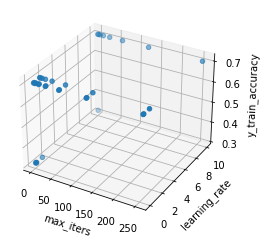

In [29]:
# Exploring Gradient Descent, to compare to the other algorithms
NN_GD()

Exploring Randomized hill climbing...
Holding restarts constant at 10, best accuracy 0.7773 found at max_iters = 256 & learning_rate = 10.0


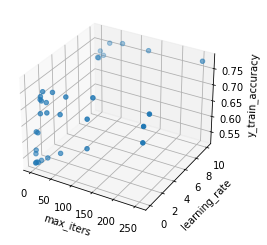

Holding max_iters constant at 256, best accuracy 0.7773 found at restarts = 5 & learning_rate = 10.0


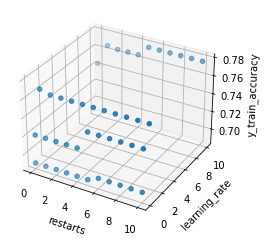

Performance vs number of iterations:


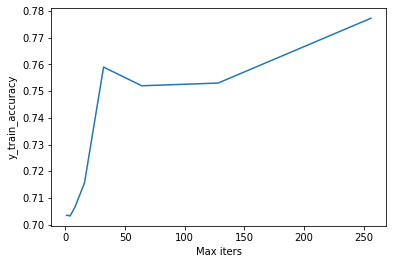

Predicting against test set: 0.7616
random_hill_climb took this much time: 9 minute(s) and 38 second(s)


In [14]:
# Exploring Randomized hill climbing:
NN_RHC()


Exploring Simulated annealing...
Holding schedule constant at default GeomDecay, best accuracy 0.7337 found at max_iters = 8 & learning_rate = 1.0


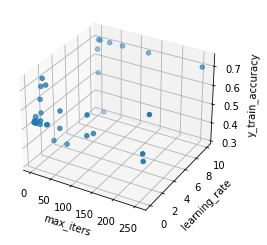

Performance vs number of iterations:


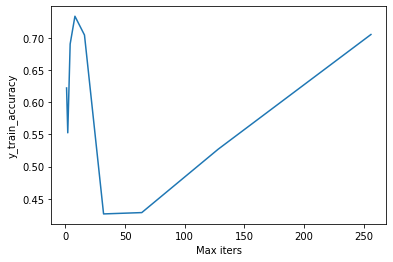

Predicting against test set: 0.7135
Exploring various decay schedules: 
Exploring geometric decay: 
Holding min_temp constant at 0.001, best accuracy 0.739 found at init_temp = 1 & decay = 0.1


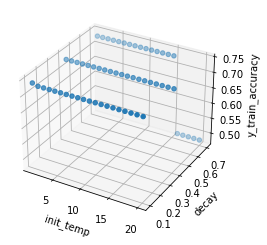

Holding decay constant at 0.1, best accuracy 0.739 found at init_temp = 1 & min_temp = 0.001


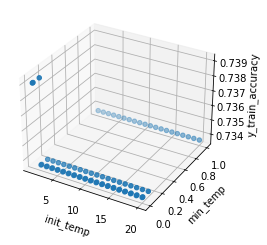

Performance vs number of iterations:


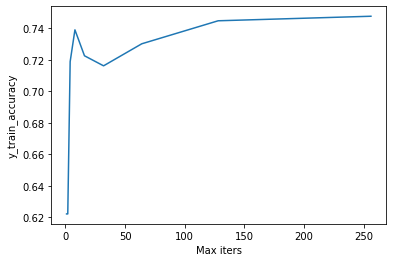

Predicting against test set: 0.7449
Exploring arithmetic decay: 
Holding min_temp constant at 0.001, best accuracy 0.7337 found at init_temp = 1 & decay = 0.1


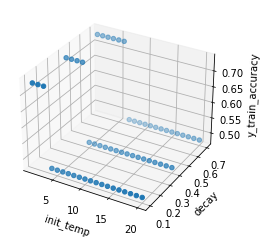

Holding decay constant at 0.1, best accuracy 0.7337 found at init_temp = 1 & min_temp = 0.001


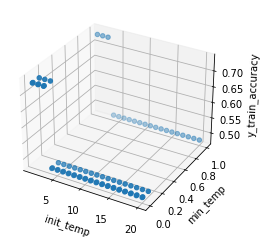

Performance vs number of iterations:


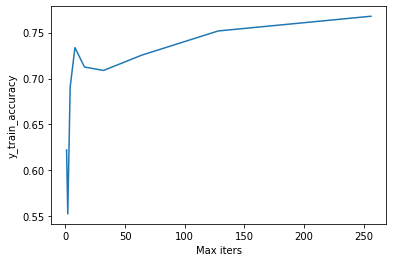

Predicting against test set: 0.7671
Exploring exponential decay: 
Holding min_temp constant at 0.001, best accuracy 0.739 found at init_temp = 1 & exp_const = 10.0


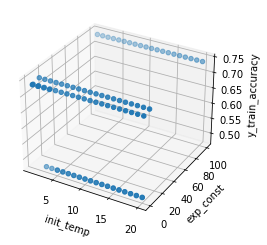

Holding exp_const constant at 10.0, best accuracy 0.739 found at init_temp = 1 & min_temp = 0.001


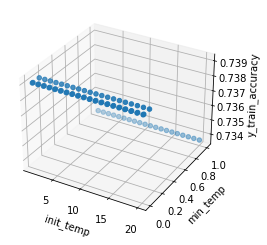

Performance vs number of iterations:


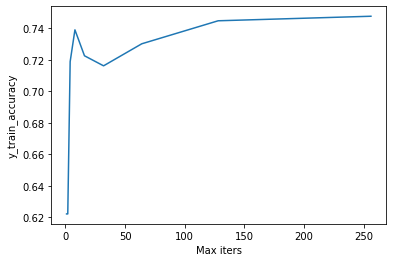

Predicting against test set: 0.7449
simulated_annealing took this much time: 1 minute(s) and 19 second(s)


In [15]:
# Exploring Simulated annealing
NN_SA()


Exploring Genetic algorithm...
Holding pop_size (5) & mutation_prob (0.5) constant, best accuracy 0.7617 found at max_iters = 256 & learning_rate = 0.01


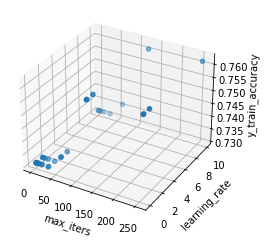

Holding max_iters (256) & learning_rate (0.01) constant, best accuracy 0.8014 found at pop_size = 15 & mutation_prob = 0.01


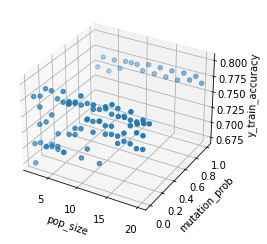

Performance vs number of iterations:


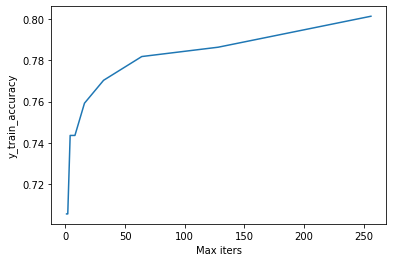

Predicting against test set: 0.8059
genetic_alg took this much time: 21 minute(s) and 38 second(s)


In [16]:
# Exploring Genetic algorithm
NN_GA()


In [17]:
# Split data into differently-sized train and test subsets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0) 

# Reinitialized dependent variables
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()

print("Done resizing data to test_size=0.1")

# Leave all other globals alone and do it all again

Done resizing data to test_size=0.1


Exploring Randomized hill climbing...
Holding restarts constant at 10, best accuracy 0.7773 found at max_iters = 256 & learning_rate = 10.0


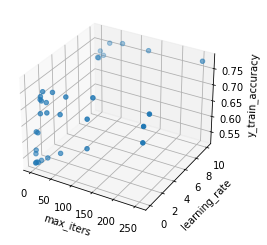

Holding max_iters constant at 256, best accuracy 0.7773 found at restarts = 5 & learning_rate = 10.0


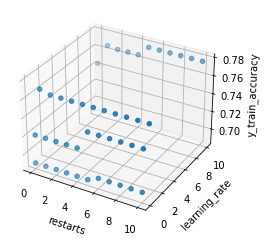

Performance vs number of iterations:


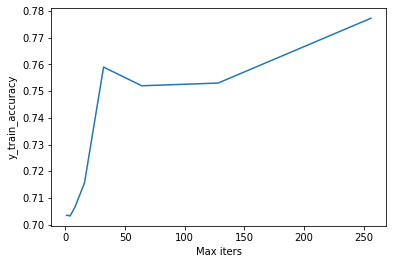

Predicting against test set: 0.7616
random_hill_climb took this much time: 10 minute(s) and 4 second(s)


In [18]:
NN_RHC()

Exploring Simulated annealing...
Holding schedule constant at default GeomDecay, best accuracy 0.7337 found at max_iters = 8 & learning_rate = 1.0


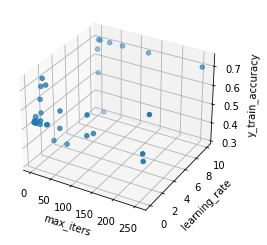

Performance vs number of iterations:


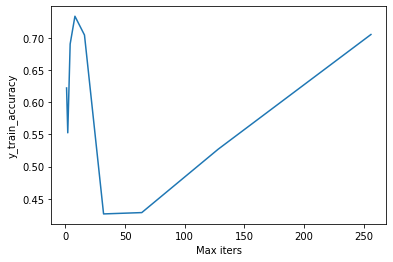

Predicting against test set: 0.7135
Exploring various decay schedules: 
Exploring geometric decay: 
Holding min_temp constant at 0.001, best accuracy 0.739 found at init_temp = 1 & decay = 0.1


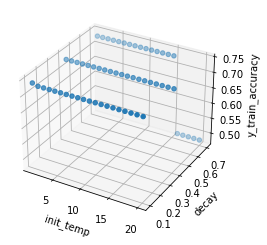

Holding decay constant at 0.1, best accuracy 0.739 found at init_temp = 1 & min_temp = 0.001


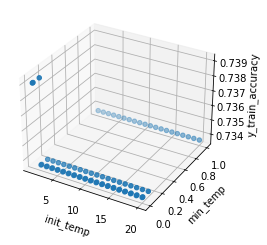

Performance vs number of iterations:


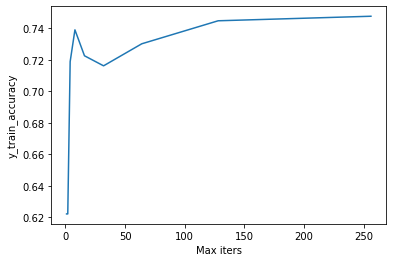

Predicting against test set: 0.7449
Exploring arithmetic decay: 
Holding min_temp constant at 0.001, best accuracy 0.7337 found at init_temp = 1 & decay = 0.1


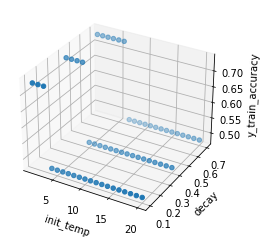

Holding decay constant at 0.1, best accuracy 0.7337 found at init_temp = 1 & min_temp = 0.001


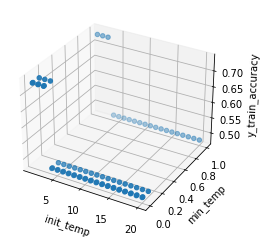

Performance vs number of iterations:


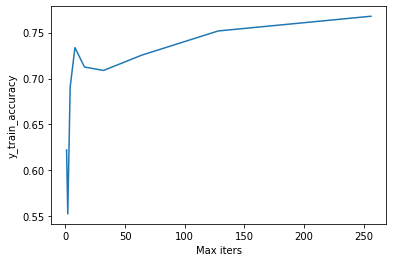

Predicting against test set: 0.7671
Exploring exponential decay: 
Holding min_temp constant at 0.001, best accuracy 0.739 found at init_temp = 1 & exp_const = 10.0


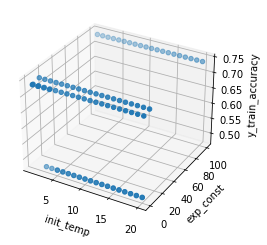

Holding exp_const constant at 10.0, best accuracy 0.739 found at init_temp = 1 & min_temp = 0.001


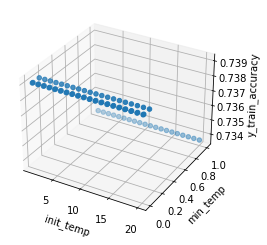

Performance vs number of iterations:


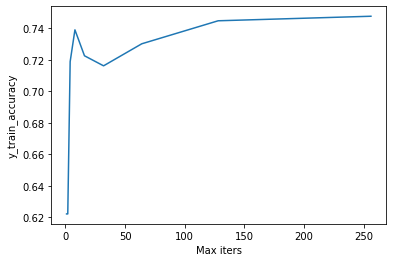

Predicting against test set: 0.7449
simulated_annealing took this much time: 1 minute(s) and 21 second(s)


In [19]:
NN_SA()

Exploring Genetic algorithm...
Holding pop_size (5) & mutation_prob (0.5) constant, best accuracy 0.7617 found at max_iters = 256 & learning_rate = 0.01


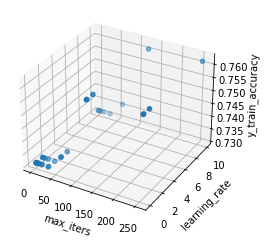

Holding max_iters (256) & learning_rate (0.01) constant, best accuracy 0.8014 found at pop_size = 15 & mutation_prob = 0.01


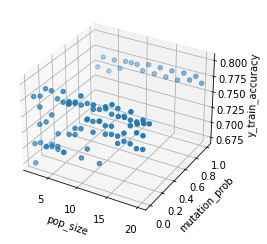

Performance vs number of iterations:


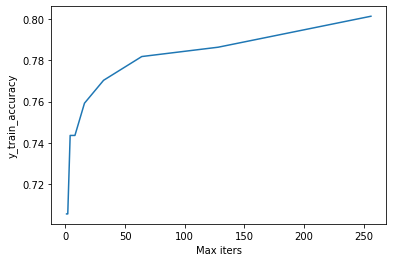

Predicting against test set: 0.8059
genetic_alg took this much time: 21 minute(s) and 51 second(s)


In [20]:
NN_GA()

In [21]:
# Split data into differently-sized train and test subsets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

# Reinitialized dependent variables
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()

print("Done resizing data to test_size=0.3")

# Leave all other globals alone and do it all again

Done resizing data to test_size=0.3


Exploring Randomized hill climbing...
Holding restarts constant at 10, best accuracy 0.7903 found at max_iters = 256 & learning_rate = 1.0


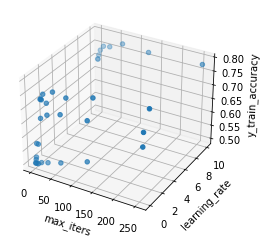

Holding max_iters constant at 256, best accuracy 0.7903 found at restarts = 2 & learning_rate = 1.0


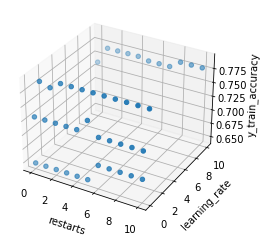

Performance vs number of iterations:


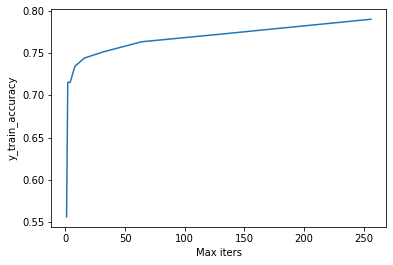

Predicting against test set: 0.7639
random_hill_climb took this much time: 7 minute(s) and 55 second(s)


In [22]:
NN_RHC()

Exploring Simulated annealing...
Holding schedule constant at default GeomDecay, best accuracy 0.7319 found at max_iters = 8 & learning_rate = 1.0


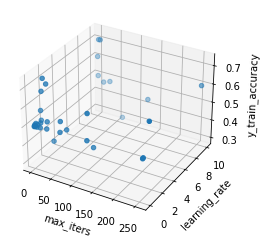

Performance vs number of iterations:


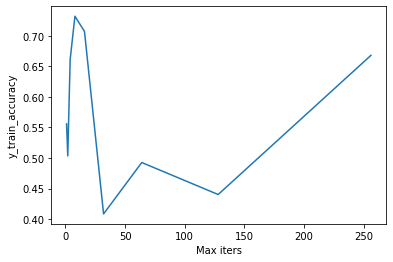

Predicting against test set: 0.7207
Exploring various decay schedules: 
Exploring geometric decay: 
Holding min_temp constant at 0.001, best accuracy 0.7388 found at init_temp = 1 & decay = 0.1


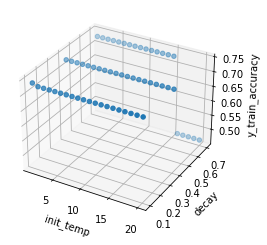

Holding decay constant at 0.1, best accuracy 0.7388 found at init_temp = 1 & min_temp = 0.001


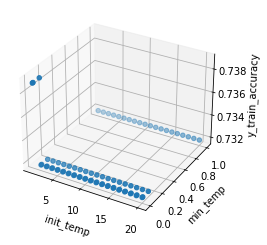

Performance vs number of iterations:


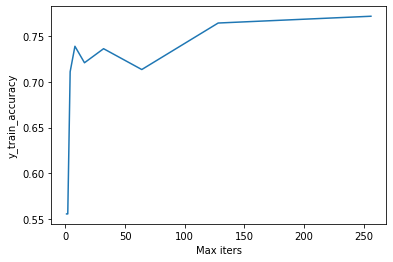

Predicting against test set: 0.7571
Exploring arithmetic decay: 
Holding min_temp constant at 0.001, best accuracy 0.7319 found at init_temp = 1 & decay = 0.1


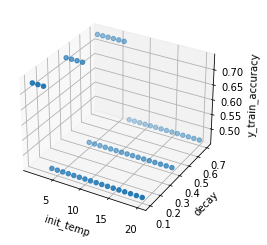

Holding decay constant at 0.1, best accuracy 0.7319 found at init_temp = 1 & min_temp = 0.001


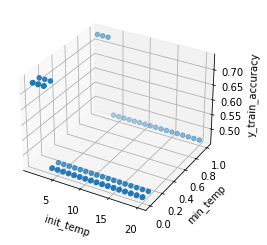

Performance vs number of iterations:


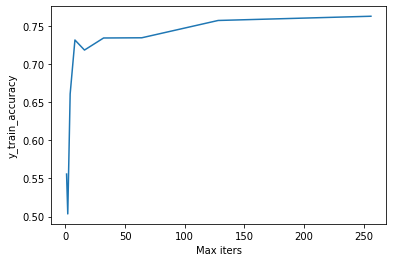

Predicting against test set: 0.7559
Exploring exponential decay: 
Holding min_temp constant at 0.001, best accuracy 0.7388 found at init_temp = 1 & exp_const = 10.0


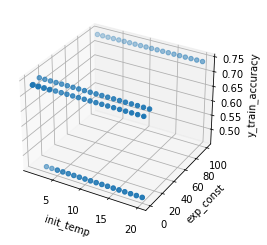

Holding exp_const constant at 10.0, best accuracy 0.7388 found at init_temp = 1 & min_temp = 0.001


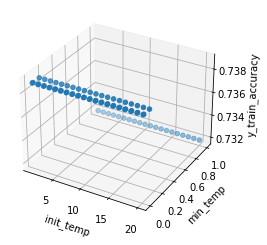

Performance vs number of iterations:


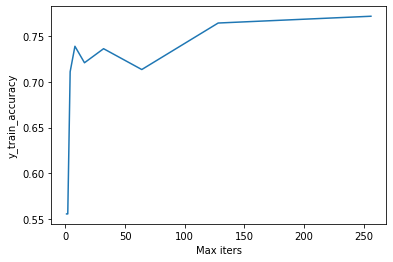

Predicting against test set: 0.7571
simulated_annealing took this much time: 1 minute(s) and 6 second(s)


In [23]:
NN_SA()

Exploring Genetic algorithm...
Holding pop_size (5) & mutation_prob (0.5) constant, best accuracy 0.7583 found at max_iters = 256 & learning_rate = 0.01


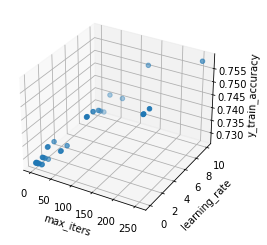

Holding max_iters (256) & learning_rate (0.01) constant, best accuracy 0.803 found at pop_size = 12 & mutation_prob = 0.01


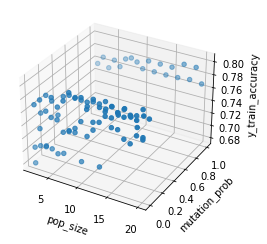

Performance vs number of iterations:


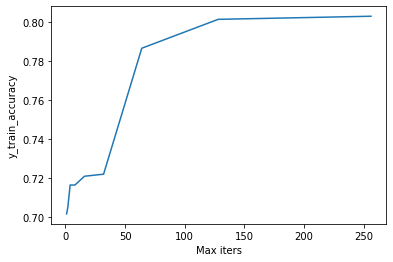

Predicting against test set: 0.7793
genetic_alg took this much time: 18 minute(s) and 5 second(s)


In [24]:
NN_GA()